In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("ready_data.xlsx")

In [4]:
# Convert payment_date using the correct format (DD/MM/YYYY HH:MM:SS)
df['payment_date'] = pd.to_datetime(df['payment_date'], format="%d/%m/%Y %H:%M:%S", errors='coerce')


In [5]:

# Filter out free tickets (price = 0)
df_paid = df[df['paid'] > 0].copy()


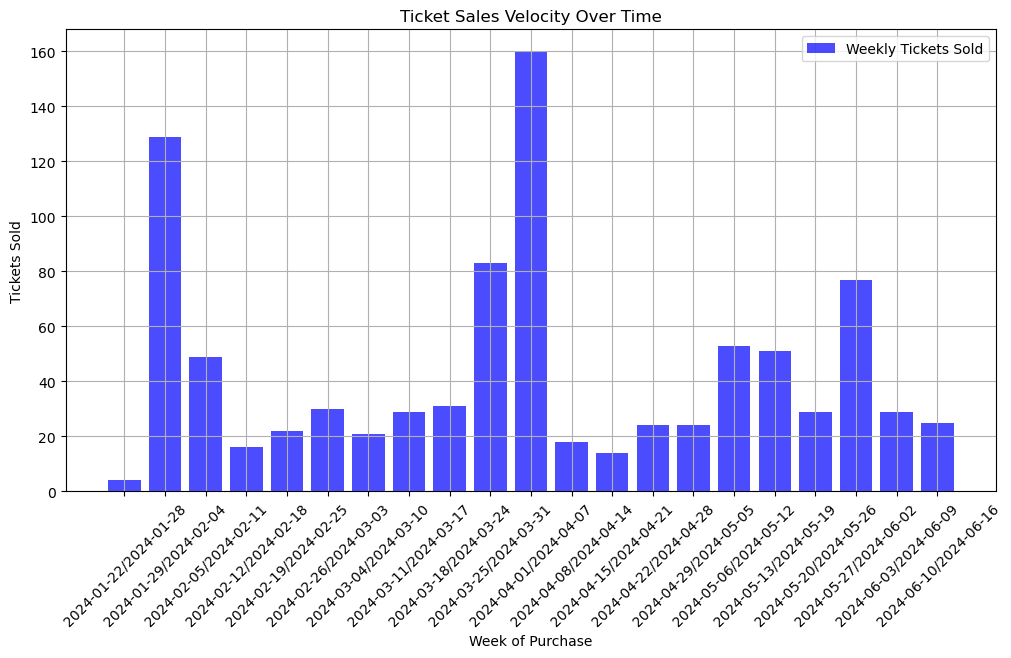

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


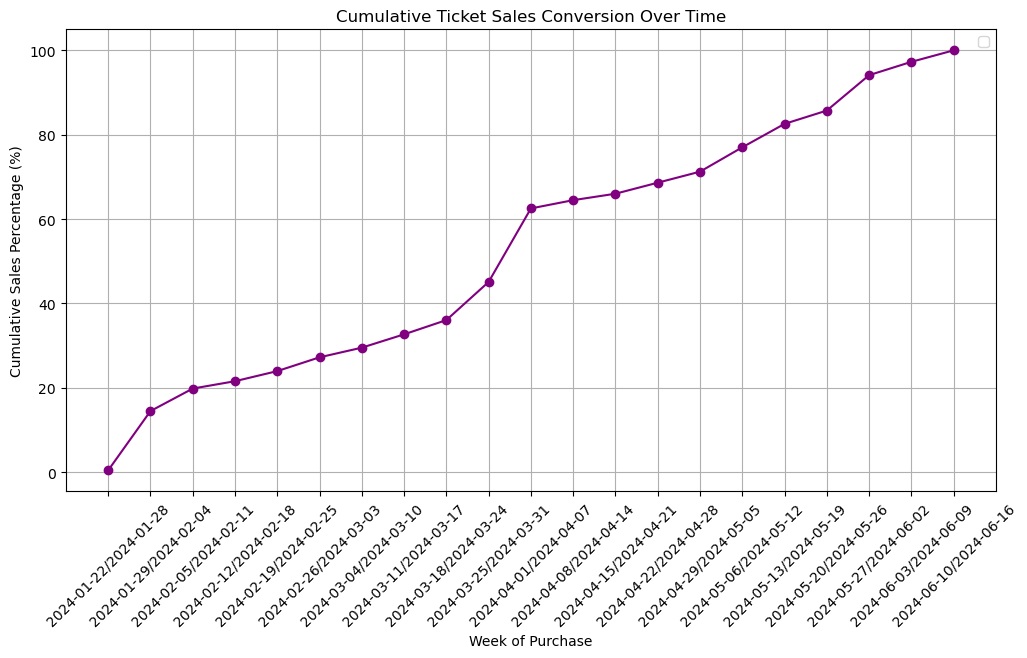

In [7]:
# Create week-based time period
df_paid['week_of_purchase'] = df_paid['payment_date'].dt.to_period('W')


# Aggregate ticket sales per week
weekly_sales = df_paid.groupby('week_of_purchase').agg(
    total_tickets_sold=('event_registration_uid', 'count'),
    avg_price=('paid', 'mean')
)

# Calculate cumulative sales percentage
weekly_sales['cumulative_sales'] = weekly_sales['total_tickets_sold'].cumsum()
weekly_sales['cumulative_sales_percentage'] = (weekly_sales['cumulative_sales'] / weekly_sales['total_tickets_sold'].sum()) * 100

# Identify key pricing dates
early_bird_end = df_paid[df_paid['ticket_category'] == 'Early Bird']['payment_date'].max()
spring_sale_start = df_paid[df_paid['ticket_category'] == 'Spring Sale']['payment_date'].min()
full_price_start = df_paid[df_paid['ticket_category'] == 'Full Price']['payment_date'].min()

# Convert key dates to string format for plotting
early_bird_end_str = early_bird_end.strftime("%Y-%m-%d") if pd.notna(early_bird_end) else None
spring_sale_start_str = spring_sale_start.strftime("%Y-%m-%d") if pd.notna(spring_sale_start) else None
full_price_start_str = full_price_start.strftime("%Y-%m-%d") if pd.notna(full_price_start) else None

# Plot weekly ticket sales velocity
plt.figure(figsize=(12, 6))
plt.bar(weekly_sales.index.astype(str), weekly_sales['total_tickets_sold'], color='blue', alpha=0.7, label="Weekly Tickets Sold")
plt.xlabel("Week of Purchase")
plt.ylabel("Tickets Sold")
plt.title("Ticket Sales Velocity Over Time")
plt.xticks(rotation=45)


plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative sales conversion trend
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index.astype(str), weekly_sales['cumulative_sales_percentage'], marker='o', linestyle='-', color='purple')
plt.xlabel("Week of Purchase")
plt.ylabel("Cumulative Sales Percentage (%)")
plt.title("Cumulative Ticket Sales Conversion Over Time")
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Filter relevant columns for bundle analysis
bundle_analysis_df = df_paid[['net_id', 'payment_date', 'paid', 'gaw', 'gala', 'bundle_ticket', 'ticket_category']]

# Ensure bundle_ticket is correctly classified
bundle_analysis_df['bought_bundle'] = bundle_analysis_df['bundle_ticket'] == 'Bundle Ticket'

# Identify bundle release date
bundle_release_date = pd.to_datetime("2024-05-15")

# Create a flag for purchases made after bundle release
bundle_analysis_df['purchased_after_bundle_release'] = bundle_analysis_df['payment_date'] >= bundle_release_date

# Group by net_id to analyze purchase behavior
purchase_behavior = bundle_analysis_df.groupby('net_id').agg(
    purchased_after_bundle_release=('purchased_after_bundle_release', 'max'),  # Track if purchase was post-bundle release
    bought_gala=('gala', lambda x: (x > 0).any()),  # Identify if at least one Gala ticket was bought
    bought_bundle=('bought_bundle', 'max')  # Identify if at least one bundle was bought
).reset_index()

purchase_behavior


C:\Users\valer\AppData\Local\Temp\ipykernel_16660\3708836413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bundle_analysis_df['bought_bundle'] = bundle_analysis_df['bundle_ticket'] == 'Bundle Ticket'
C:\Users\valer\AppData\Local\Temp\ipykernel_16660\3708836413.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bundle_analysis_df['purchased_after_bundle_release'] = bundle_analysis_df['payment_date'] >= bundle_release_date


,net_id,purchased_after_bundle_release,bought_gala,bought_bundle
0,00ca81fe-2767-e211-90d5-005056b42592,True,False,False
1,01a7b4c2-f7b2-e011-b3b5-02bf0a09015e,True,False,False
2,01b3a252-fe32-e911-a954-000d3a454330,True,True,True
3,02797703-a25d-e111-8310-005056b42592,False,False,False
4,02CB422A-E7A4-E111-8BB9-005056B42592,True,False,False
...,...,...,...,...
624,feaf304a-0f93-e211-9c17-005056b41464,False,False,False
625,febbaf44-4fb2-e111-8bb9-005056b42592,False,False,False
626,ff8e7a68-c875-e011-8943-005056b42592,False,False,False
627,ff944daf-edfe-e011-bcc1-02bf0a09015e,False,True,False


In [11]:
# Compare likelihood of purchasing Gala based on bundle availability and usage
bundle_effectiveness = purchase_behavior.groupby(['purchased_after_bundle_release', 'bought_bundle'])['bought_gala'].mean()

# Display results
bundle_effectiveness

purchased_after_bundle_release  bought_bundle
False                           False            0.237581
True                            False            0.268966
                                True             1.000000
Name: bought_gala, dtype: float64